In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.options.mode.chained_assignment = None

# Importing

In [2]:
os.chdir("C:/Users/Tom/Documents/Course/Semester 3/Project/Data Sets/")

In [3]:
#Importing the Indoor Air Quality sensor data
IAQ_LR = pd.read_csv("IAQ_livingroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
IAQ_KR = pd.read_csv("IAQ_kitchen.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
IAQ_BR = pd.read_csv("IAQ_bedroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)

In [4]:
#Creating datasets to hold just the data for when devices were together for calibration purposes
Cal_LR = IAQ_LR[IAQ_LR["Calibration"] == 1].drop(["Calibration"], axis=1)
Cal_KR = IAQ_KR[IAQ_KR["Calibration"] == 1].drop(["Calibration"], axis=1)
Cal_BR = IAQ_BR[IAQ_BR["Calibration"] == 1].drop(["Calibration"], axis=1)

#Removing the calibration observations from our sensor data
IAQ_LR = IAQ_LR[IAQ_LR["Calibration"] == 0].drop(["Calibration"], axis=1)
IAQ_KR = IAQ_KR[IAQ_KR["Calibration"] == 0].drop(["Calibration"], axis=1)
IAQ_BR = IAQ_BR[IAQ_BR["Calibration"] == 0].drop(["Calibration"], axis=1)

In [5]:
#Bringing in the Occupant Activity. Shower holds a variable only used on House 2 to see if it made any impact on PM2.5
activity_LR = pd.read_csv("activity_livingroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
activity_KR = pd.read_csv("activity_Kitchen.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
activity_BR = pd.read_csv("activity_Bedroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)
shower = pd.read_csv("activity_bathroom.csv", parse_dates=['Date and Time'], index_col='Date and Time', dayfirst=True)


In [6]:
#Joining all activities in the same dataset as they have unique names such as "LR_MaxOccupancy", "BR_MaxOccupancy" and so on.
activity = pd.merge(activity_LR, activity_KR, left_index=True, right_index=True).merge(
    activity_BR, left_index=True, right_index=True).merge(shower, left_index=True, right_index=True)

In [7]:
#To consider time as a feature in our model, we've created a feature storing all 24 hours and one for Time of day

activity['Hour'] = activity.index.strftime('%H').astype(int)
activity["timeOfDay"]=pd.cut(activity.index.hour, [-1, 5, 11, 17, 24], labels=['Night', "Morning", 'Afternoon', 'Evening'])
activity["timeOfDay"] = activity["timeOfDay"].cat.codes

# Calibration

In this section we'll analyse the calibration plots for House 1 and 2 for all sensor features. If they're highly correlated, we'll bring their into agreement through their difference in means. If not, they'll be excluded from the model.

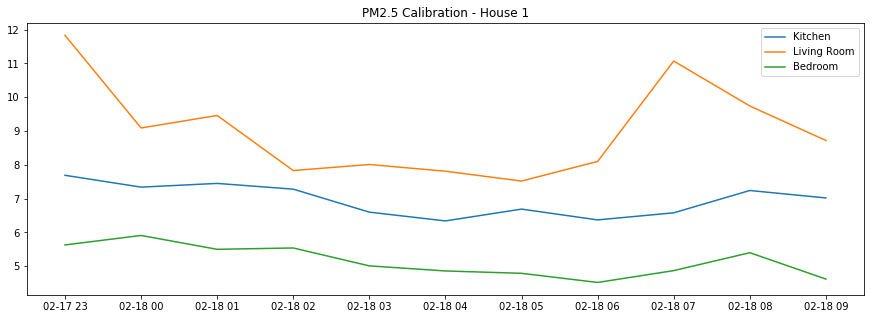

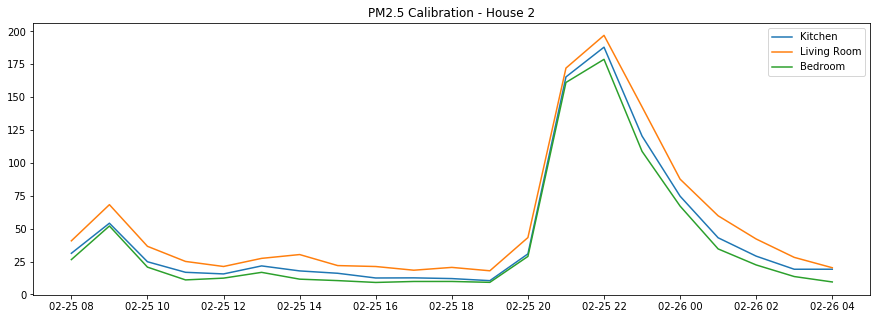

In [8]:
###############################################################################
################################## P M 2 . 5 ##################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["PM2.5"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["PM2.5"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["PM2.5"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("PM2.5 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["PM2.5"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["PM2.5"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["PM2.5"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("PM2.5 Calibration - House 2")
plt.show();

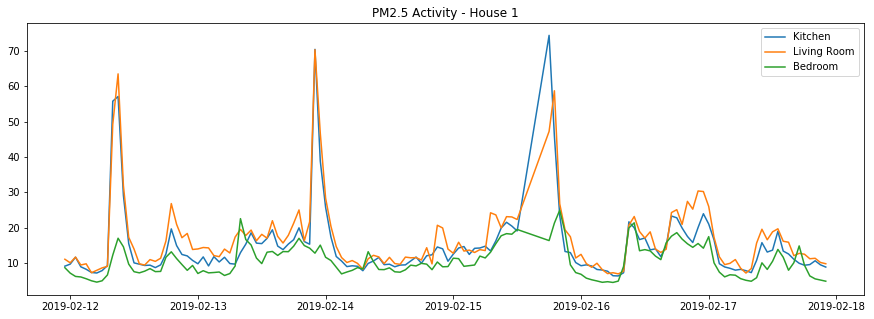

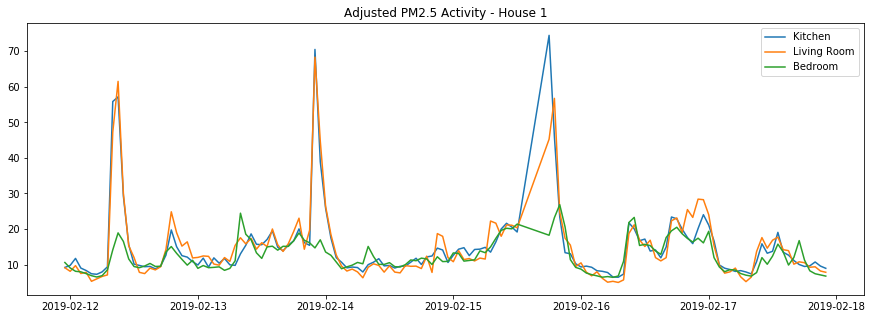

In [9]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("PM2.5 Activity - House 1")
plt.show()

KR1_Cal_PM25_mean = Cal_KR["PM2.5"][Cal_KR["House"]==2].mean()
LR1_Cal_PM25_mean = Cal_LR["PM2.5"][Cal_LR["House"]==2].mean()
BR1_Cal_PM25_mean = Cal_BR["PM2.5"][Cal_BR["House"]==2].mean()

H1_Cal_PM25_mean = (KR1_Cal_PM25_mean + LR1_Cal_PM25_mean + BR1_Cal_PM25_mean)/3

KR1_PM25_adjustment = KR1_Cal_PM25_mean - H1_Cal_PM25_mean
LR1_PM25_adjustment = LR1_Cal_PM25_mean - H1_Cal_PM25_mean
BR1_PM25_adjustment = BR1_Cal_PM25_mean - H1_Cal_PM25_mean

IAQ_KR["PM2.5"][IAQ_KR["House"]==2] -= KR1_PM25_adjustment
IAQ_LR["PM2.5"][IAQ_LR["House"]==2] -= LR1_PM25_adjustment
IAQ_BR["PM2.5"][IAQ_BR["House"]==2] -= BR1_PM25_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted PM2.5 Activity - House 1")
plt.show();

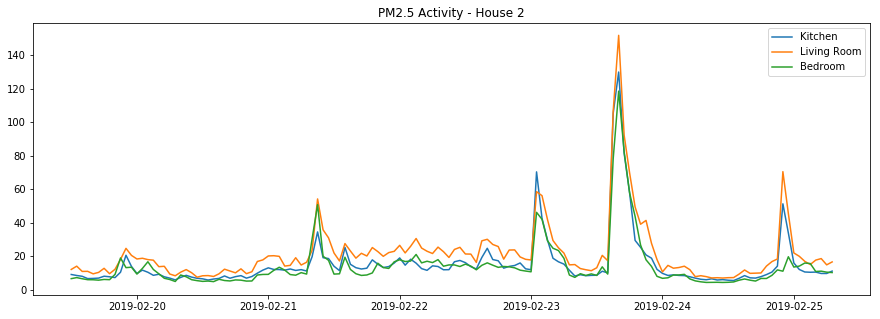

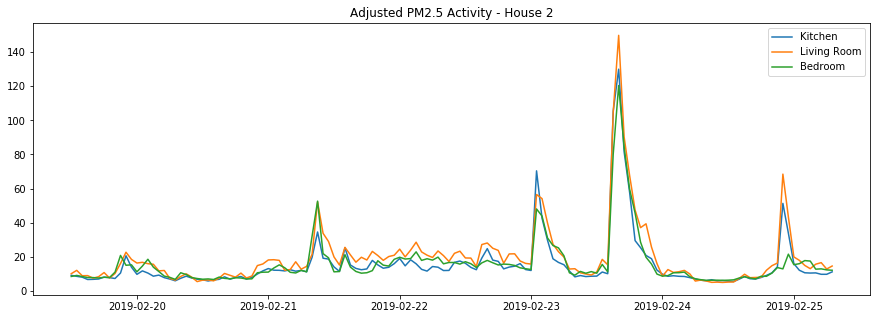

In [10]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("PM2.5 Activity - House 2")
plt.show()

KR2_Cal_PM25_mean = Cal_KR["PM2.5"][Cal_KR["House"]==3].mean()
LR2_Cal_PM25_mean = Cal_LR["PM2.5"][Cal_LR["House"]==3].mean()
BR2_Cal_PM25_mean = Cal_BR["PM2.5"][Cal_BR["House"]==3].mean()

H2_Cal_PM25_mean = (KR2_Cal_PM25_mean + LR2_Cal_PM25_mean + BR2_Cal_PM25_mean)/3

KR2_PM25_adjustment = KR2_Cal_PM25_mean - H2_Cal_PM25_mean
LR2_PM25_adjustment = LR2_Cal_PM25_mean - H2_Cal_PM25_mean
BR2_PM25_adjustment = BR2_Cal_PM25_mean - H2_Cal_PM25_mean

IAQ_KR["PM2.5"][IAQ_KR["House"]==3] -= KR1_PM25_adjustment
IAQ_LR["PM2.5"][IAQ_LR["House"]==3] -= LR1_PM25_adjustment
IAQ_BR["PM2.5"][IAQ_BR["House"]==3] -= BR1_PM25_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["PM2.5"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["PM2.5"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["PM2.5"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted PM2.5 Activity - House 2")
plt.show();

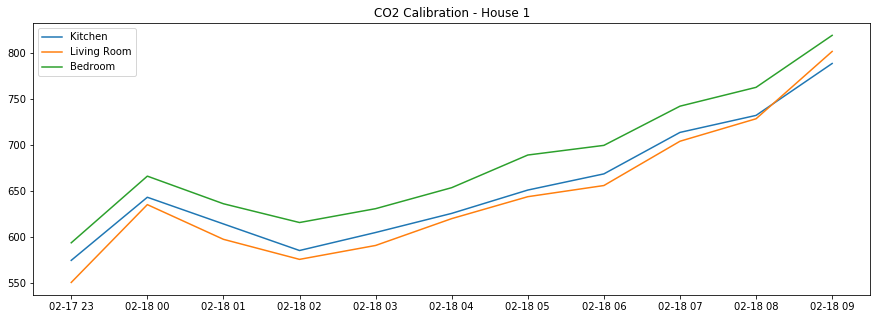

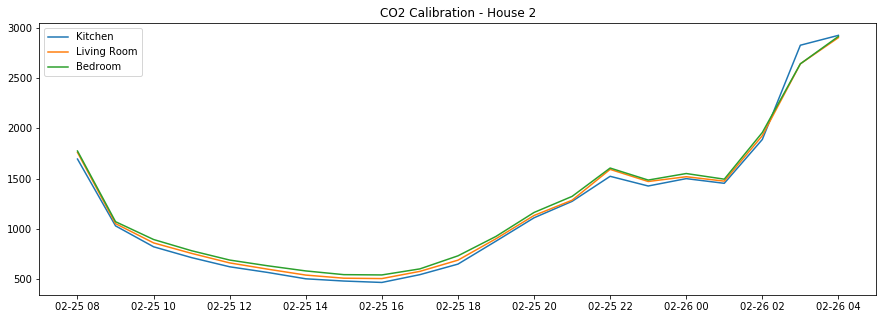

In [11]:
###############################################################################
#################################### C O 2 ####################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["CO2"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["CO2"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["CO2"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("CO2 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["CO2"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["CO2"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["CO2"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("CO2 Calibration - House 2")
plt.show();

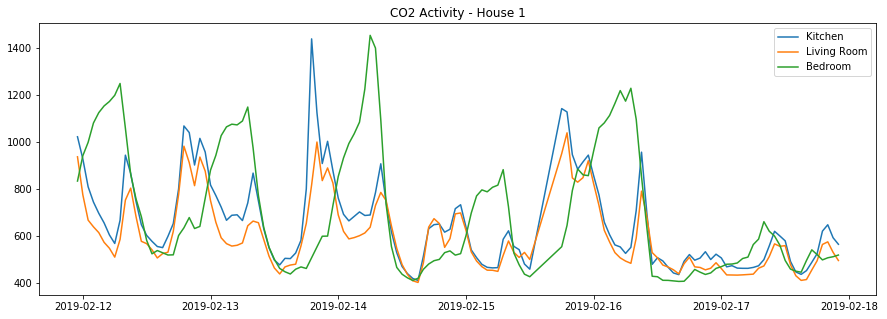

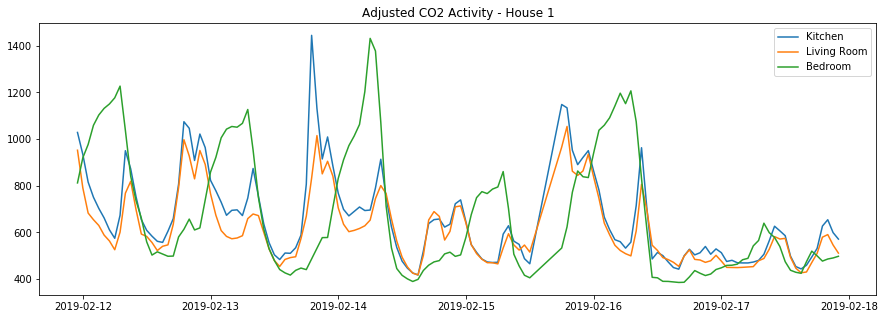

In [12]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("CO2 Activity - House 1")
plt.show()

KR1_Cal_CO2_mean = Cal_KR["CO2"][Cal_KR["House"]==2].mean()
LR1_Cal_CO2_mean = Cal_LR["CO2"][Cal_LR["House"]==2].mean()
BR1_Cal_CO2_mean = Cal_BR["CO2"][Cal_BR["House"]==2].mean()

H1_Cal_CO2_mean = (KR1_Cal_CO2_mean + LR1_Cal_CO2_mean + BR1_Cal_CO2_mean)/3

KR1_CO2_adjustment = KR1_Cal_CO2_mean - H1_Cal_CO2_mean
LR1_CO2_adjustment = LR1_Cal_CO2_mean - H1_Cal_CO2_mean
BR1_CO2_adjustment = BR1_Cal_CO2_mean - H1_Cal_CO2_mean

IAQ_KR["CO2"][IAQ_KR["House"]==2] -= KR1_CO2_adjustment
IAQ_LR["CO2"][IAQ_LR["House"]==2] -= LR1_CO2_adjustment
IAQ_BR["CO2"][IAQ_BR["House"]==2] -= BR1_CO2_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted CO2 Activity - House 1")
plt.show();

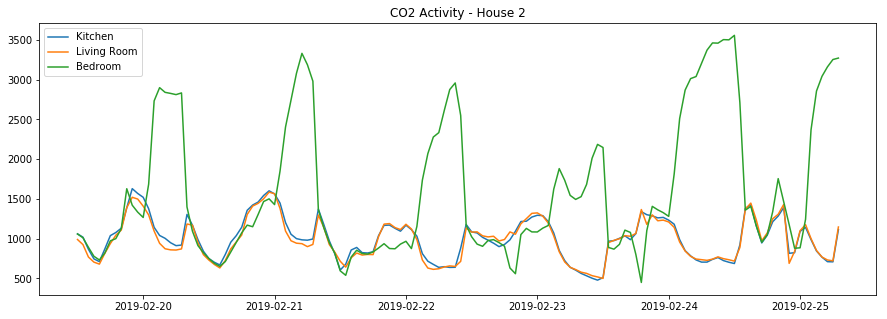

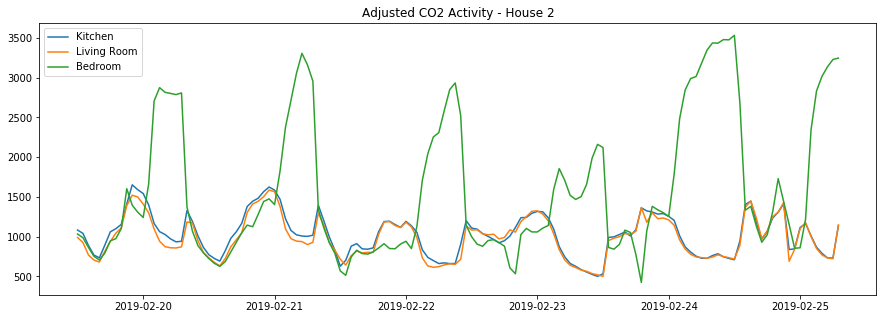

In [13]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("CO2 Activity - House 2")
plt.show()

KR2_Cal_CO2_mean = Cal_KR["CO2"][Cal_KR["House"]==3].mean()
LR2_Cal_CO2_mean = Cal_LR["CO2"][Cal_LR["House"]==3].mean()
BR2_Cal_CO2_mean = Cal_BR["CO2"][Cal_BR["House"]==3].mean()

H2_Cal_CO2_mean = (KR2_Cal_CO2_mean + LR2_Cal_CO2_mean + BR2_Cal_CO2_mean)/3

KR2_CO2_adjustment = KR2_Cal_CO2_mean - H2_Cal_CO2_mean
LR2_CO2_adjustment = LR2_Cal_CO2_mean - H2_Cal_CO2_mean
BR2_CO2_adjustment = BR2_Cal_CO2_mean - H2_Cal_CO2_mean

IAQ_KR["CO2"][IAQ_KR["House"]==3] -= KR2_CO2_adjustment
IAQ_LR["CO2"][IAQ_LR["House"]==3] -= LR2_CO2_adjustment
IAQ_BR["CO2"][IAQ_BR["House"]==3] -= BR2_CO2_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["CO2"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["CO2"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["CO2"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted CO2 Activity - House 2")
plt.show();

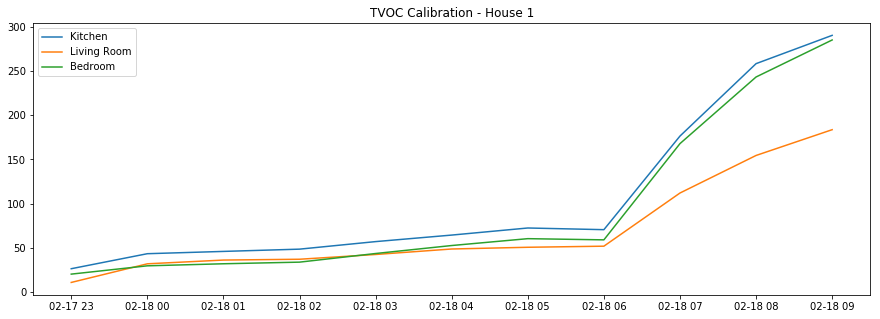

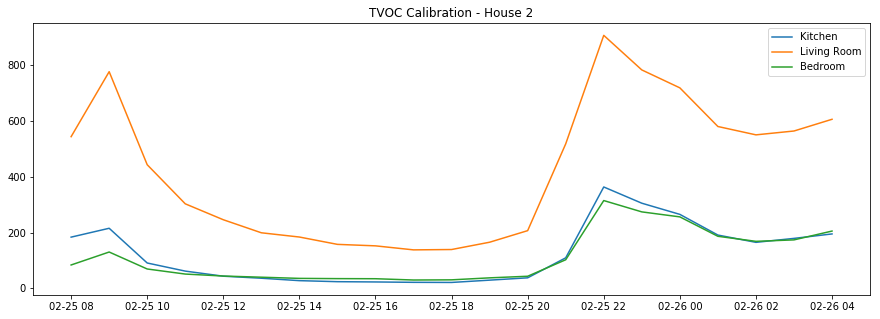

In [14]:
###############################################################################
################################### T V O C ###################################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["TVOC"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["TVOC"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["TVOC"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("TVOC Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["TVOC"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["TVOC"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["TVOC"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("TVOC Calibration - House 2")
plt.show();

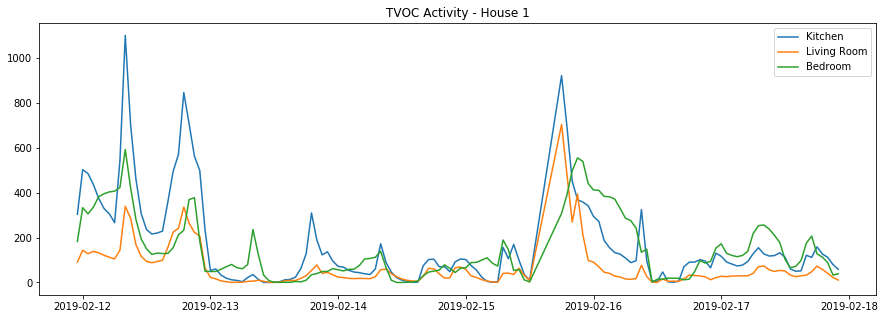

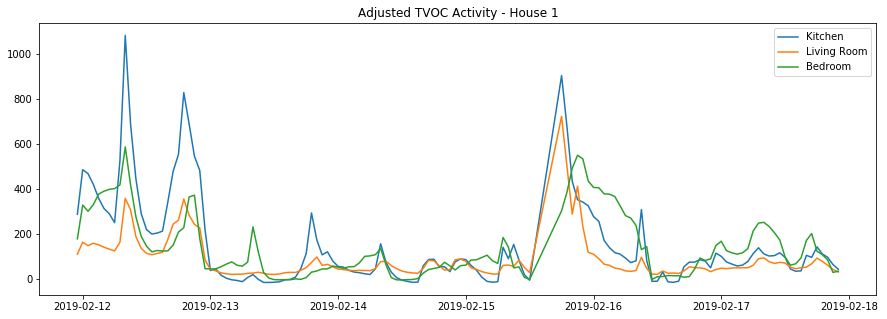

In [15]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("TVOC Activity - House 1")
plt.show()

KR1_Cal_TVOC_mean = Cal_KR["TVOC"][Cal_KR["House"]==2].mean()
LR1_Cal_TVOC_mean = Cal_LR["TVOC"][Cal_LR["House"]==2].mean()
BR1_Cal_TVOC_mean = Cal_BR["TVOC"][Cal_BR["House"]==2].mean()

H1_Cal_TVOC_mean = (KR1_Cal_TVOC_mean + LR1_Cal_TVOC_mean + BR1_Cal_TVOC_mean)/3

KR1_TVOC_adjustment = KR1_Cal_TVOC_mean - H1_Cal_TVOC_mean
LR1_TVOC_adjustment = LR1_Cal_TVOC_mean - H1_Cal_TVOC_mean
BR1_TVOC_adjustment = BR1_Cal_TVOC_mean - H1_Cal_TVOC_mean

IAQ_KR["adj_TVOC"] = IAQ_KR["TVOC"][IAQ_KR["House"]==2] - KR1_TVOC_adjustment
IAQ_LR["adj_TVOC"] = IAQ_LR["TVOC"][IAQ_LR["House"]==2] - LR1_TVOC_adjustment
IAQ_BR["adj_TVOC"] = IAQ_BR["TVOC"][IAQ_BR["House"]==2] - BR1_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 1")
plt.show();

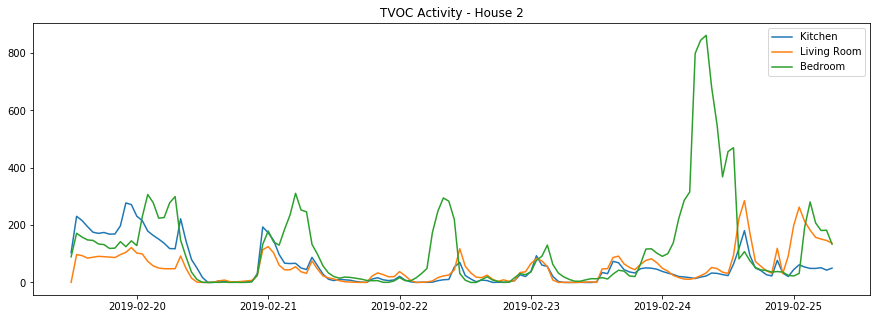

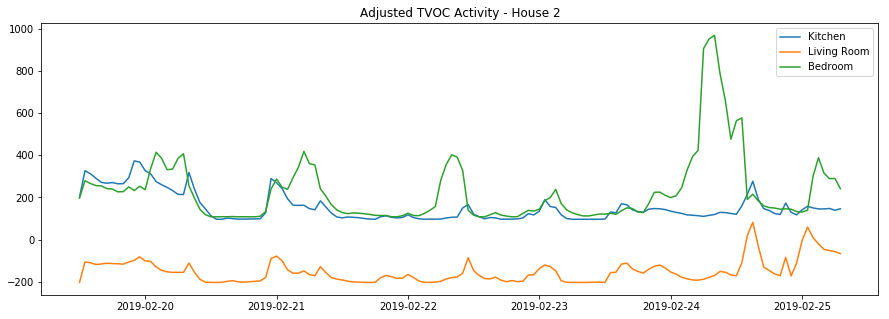

In [16]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["TVOC"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["TVOC"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["TVOC"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("TVOC Activity - House 2")
plt.show()

KR2_Cal_TVOC_mean = Cal_KR["TVOC"][Cal_KR["House"]==3].mean()
LR2_Cal_TVOC_mean = Cal_LR["TVOC"][Cal_LR["House"]==3].mean()
BR2_Cal_TVOC_mean = Cal_BR["TVOC"][Cal_BR["House"]==3].mean()

H2_Cal_TVOC_mean = (KR2_Cal_TVOC_mean + LR2_Cal_TVOC_mean + BR2_Cal_TVOC_mean)/3

KR2_TVOC_adjustment = KR2_Cal_TVOC_mean - H2_Cal_TVOC_mean
LR2_TVOC_adjustment = LR2_Cal_TVOC_mean - H2_Cal_TVOC_mean
BR2_TVOC_adjustment = BR2_Cal_TVOC_mean - H2_Cal_TVOC_mean

IAQ_KR["adj_TVOC"][IAQ_KR["House"]==3] = IAQ_KR["TVOC"][IAQ_KR["House"]==3] - KR2_TVOC_adjustment
IAQ_LR["adj_TVOC"][IAQ_LR["House"]==3] = IAQ_LR["TVOC"][IAQ_LR["House"]==3] - LR2_TVOC_adjustment
IAQ_BR["adj_TVOC"][IAQ_BR["House"]==3] = IAQ_BR["TVOC"][IAQ_BR["House"]==3] - BR2_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 2")
plt.show();

Due to how big the discrepancy is between the Living Room sensor and all the others during House 2's calibration period, applying the same formula we've been using before puts this value into the negative spectrum. As both houses have an open plan Kitchen and the kitchen and living room sensors show a high level of accordance, we'll use the calibration data from the Kitchen for the living room sensor, pending a better idea.

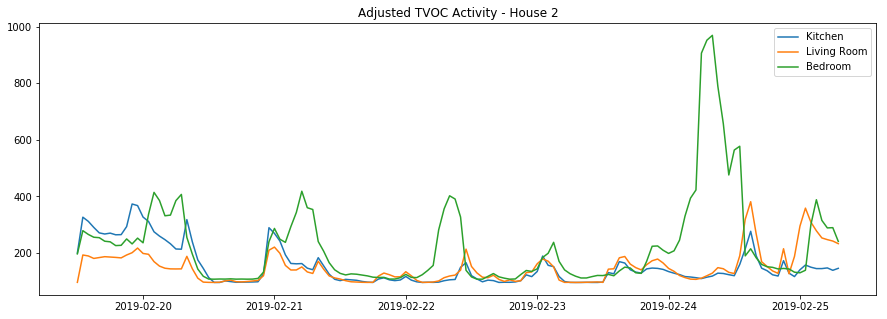

In [17]:
###############################################################################
####################### T V O C - A L T E R N A T I V E #######################
###############################################################################
################################ H O U S E   2 ################################
###############################################################################

#This is the line we've modified
LR2_TVOC_adjustment = KR2_Cal_TVOC_mean - H2_Cal_TVOC_mean

IAQ_LR["adj_TVOC"][IAQ_LR["House"]==3] = IAQ_LR["TVOC"][IAQ_LR["House"]==3] - LR2_TVOC_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["adj_TVOC"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["adj_TVOC"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["adj_TVOC"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted TVOC Activity - House 2")
plt.show();

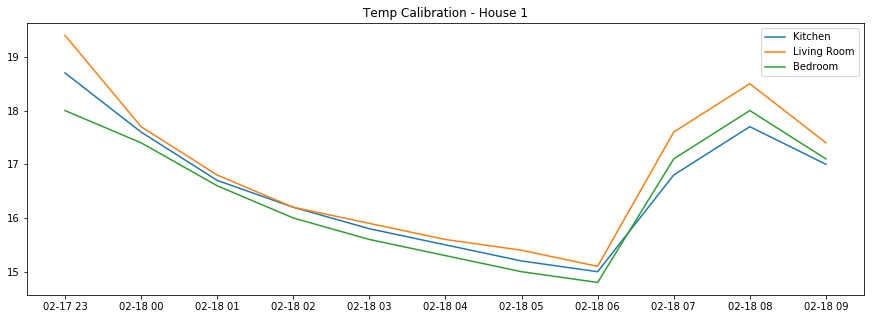

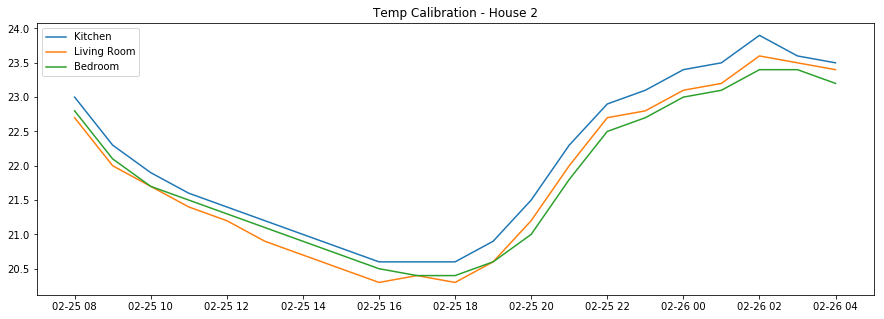

In [18]:
###############################################################################
############################ T E M P E R A T U R E ############################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Temp"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["Temp"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["Temp"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Temp Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Temp"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["Temp"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["Temp"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Temp Calibration - House 2")
plt.show();

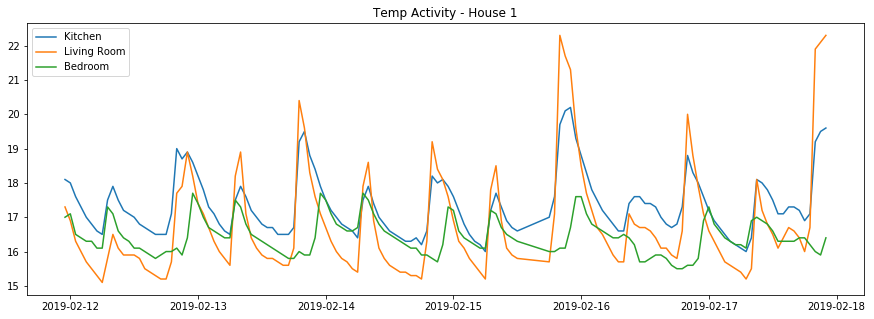

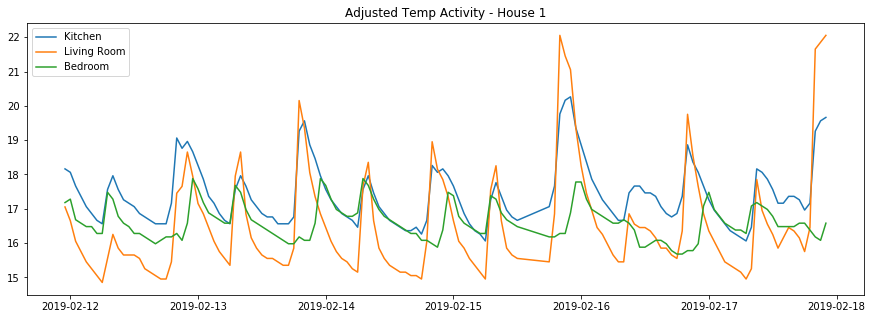

In [19]:
################################ H O U S E   1 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Temp Activity - House 1")
plt.show()

KR1_Cal_Temp_mean = Cal_KR["Temp"][Cal_KR["House"]==2].mean()
LR1_Cal_Temp_mean = Cal_LR["Temp"][Cal_LR["House"]==2].mean()
BR1_Cal_Temp_mean = Cal_BR["Temp"][Cal_BR["House"]==2].mean()

H1_Cal_Temp_mean = (KR1_Cal_Temp_mean + LR1_Cal_Temp_mean + BR1_Cal_Temp_mean)/3

KR1_Temp_adjustment = KR1_Cal_Temp_mean - H1_Cal_Temp_mean
LR1_Temp_adjustment = LR1_Cal_Temp_mean - H1_Cal_Temp_mean
BR1_Temp_adjustment = BR1_Cal_Temp_mean - H1_Cal_Temp_mean

IAQ_KR["Temp"][IAQ_KR["House"]==2] -= KR1_Temp_adjustment
IAQ_LR["Temp"][IAQ_LR["House"]==2] -= LR1_Temp_adjustment
IAQ_BR["Temp"][IAQ_BR["House"]==2] -= BR1_Temp_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted Temp Activity - House 1")
plt.show();

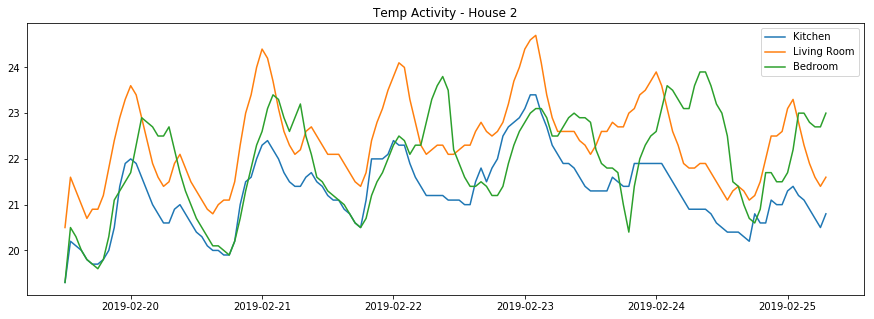

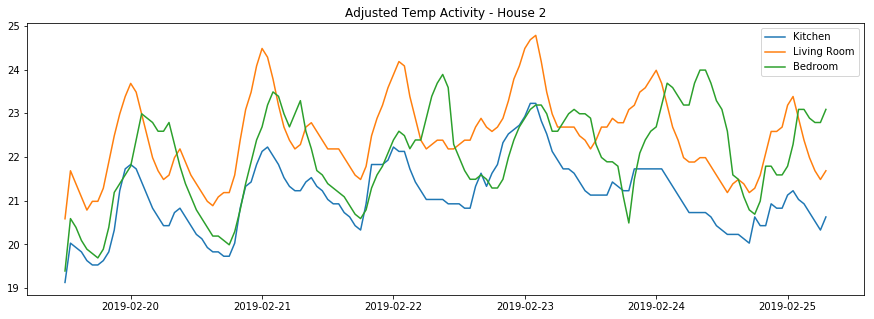

In [20]:
################################ H O U S E   2 ################################

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Temp Activity - House 2")
plt.show()

KR2_Cal_Temp_mean = Cal_KR["Temp"][Cal_KR["House"]==3].mean()
LR2_Cal_Temp_mean = Cal_LR["Temp"][Cal_LR["House"]==3].mean()
BR2_Cal_Temp_mean = Cal_BR["Temp"][Cal_BR["House"]==3].mean()

H2_Cal_Temp_mean = (KR2_Cal_Temp_mean + LR2_Cal_Temp_mean + BR2_Cal_Temp_mean)/3

KR2_Temp_adjustment = KR2_Cal_Temp_mean - H2_Cal_Temp_mean
LR2_Temp_adjustment = LR2_Cal_Temp_mean - H2_Cal_Temp_mean
BR2_Temp_adjustment = BR2_Cal_Temp_mean - H2_Cal_Temp_mean

IAQ_KR["Temp"][IAQ_KR["House"]==3] -= KR2_Temp_adjustment
IAQ_LR["Temp"][IAQ_LR["House"]==3] -= LR2_Temp_adjustment
IAQ_BR["Temp"][IAQ_BR["House"]==3] -= BR2_Temp_adjustment

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["Temp"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["Temp"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["Temp"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted Temp Activity - House 2")
plt.show();

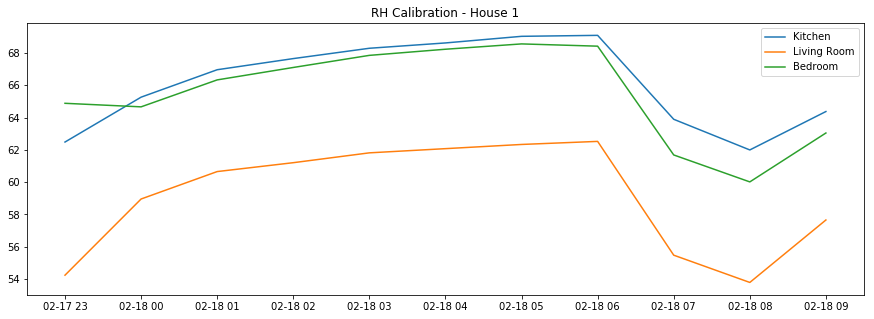

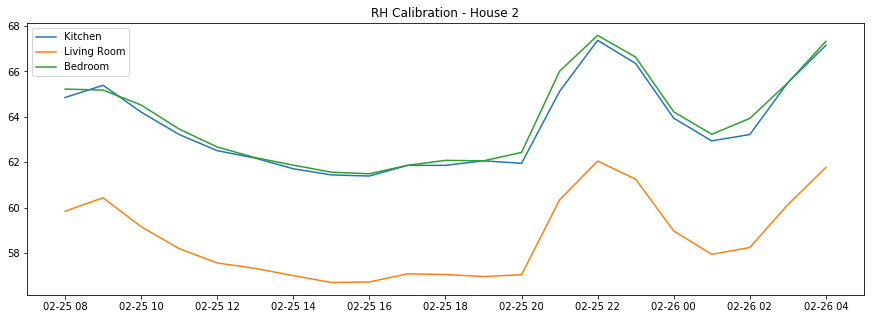

In [21]:
###############################################################################
###################### R E L A T I V E   H U M I D I T Y ######################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["RH"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["RH"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["RH"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("RH Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["RH"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["RH"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["RH"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("RH Calibration - House 2")
plt.show();

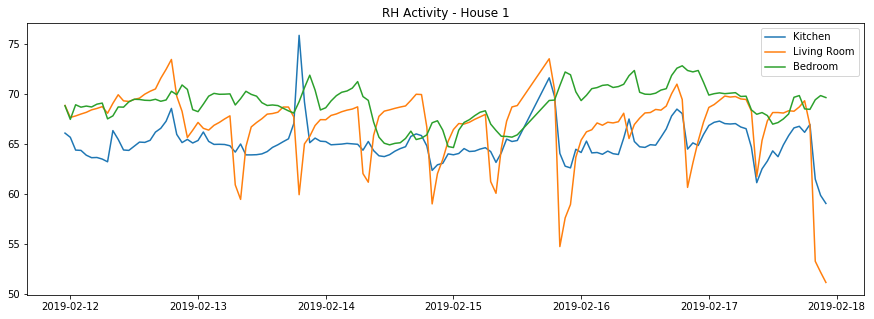

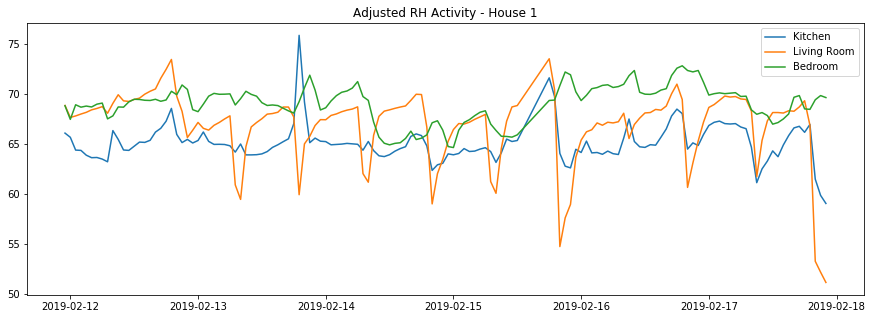

In [22]:
################################ H O U S E   1 ################################

KR1_Cal_RH_mean = Cal_KR["RH"][Cal_KR["House"]==2].mean()
LR1_Cal_RH_mean = Cal_LR["RH"][Cal_LR["House"]==2].mean()
BR1_Cal_RH_mean = Cal_BR["RH"][Cal_BR["House"]==2].mean()

H1_Cal_RH_mean = (KR1_Cal_RH_mean + LR1_Cal_RH_mean + BR1_Cal_RH_mean)/3

KR1_RH_adjustment = KR1_Cal_RH_mean - H1_Cal_RH_mean
LR1_RH_adjustment = LR1_Cal_RH_mean - H1_Cal_RH_mean
BR1_RH_adjustment = BR1_Cal_RH_mean - H1_Cal_RH_mean

IAQ_KR["RH"][IAQ_KR["House"]==2] -= KR1_RH_adjustment
IAQ_LR["RH"][IAQ_LR["House"]==2] -= LR1_RH_adjustment
IAQ_BR["RH"][IAQ_BR["House"]==2] -= BR1_RH_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("RH Activity - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted RH Activity - House 1")
plt.show();

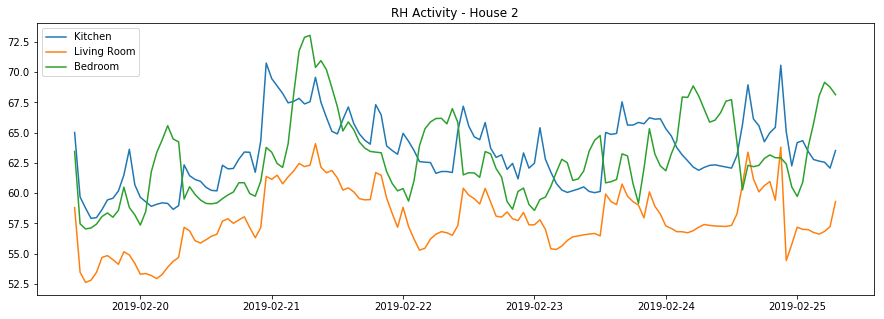

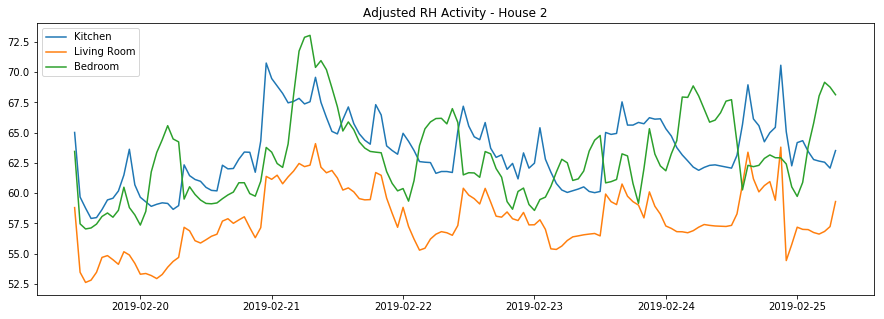

In [23]:
################################ H O U S E   2 ################################

KR2_Cal_RH_mean = Cal_KR["RH"][Cal_KR["House"]==3].mean()
LR2_Cal_RH_mean = Cal_LR["RH"][Cal_LR["House"]==3].mean()
BR2_Cal_RH_mean = Cal_BR["RH"][Cal_BR["House"]==3].mean()

H2_Cal_RH_mean = (KR2_Cal_RH_mean + LR2_Cal_RH_mean + BR2_Cal_RH_mean)/3

KR2_RH_adjustment = KR2_Cal_RH_mean - H2_Cal_RH_mean
LR2_RH_adjustment = LR2_Cal_RH_mean - H2_Cal_RH_mean
BR2_RH_adjustment = BR2_Cal_RH_mean - H2_Cal_RH_mean

IAQ_KR["RH"][IAQ_KR["House"]==3] -= KR2_RH_adjustment
IAQ_LR["RH"][IAQ_LR["House"]==3] -= LR2_RH_adjustment
IAQ_BR["RH"][IAQ_BR["House"]==3] -= BR2_RH_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("RH Activity - House 2")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["RH"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["RH"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["RH"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted RH Activity - House 2")
plt.show();

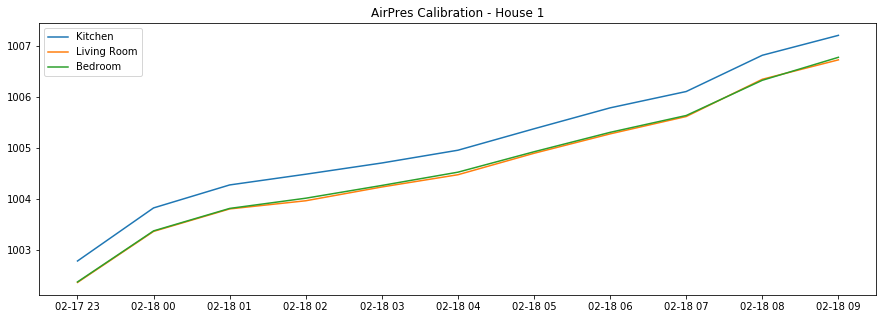

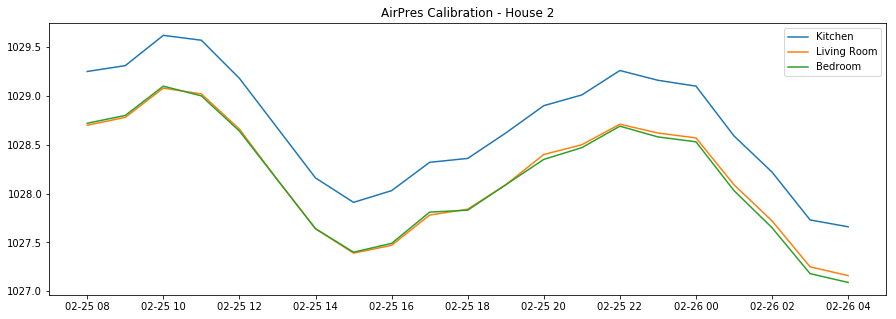

In [24]:
###############################################################################
########################### A I R   P R E S S U R E ###########################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["AirPres"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["AirPres"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["AirPres"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("AirPres Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["AirPres"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["AirPres"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["AirPres"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("AirPres Calibration - House 2")
plt.show();

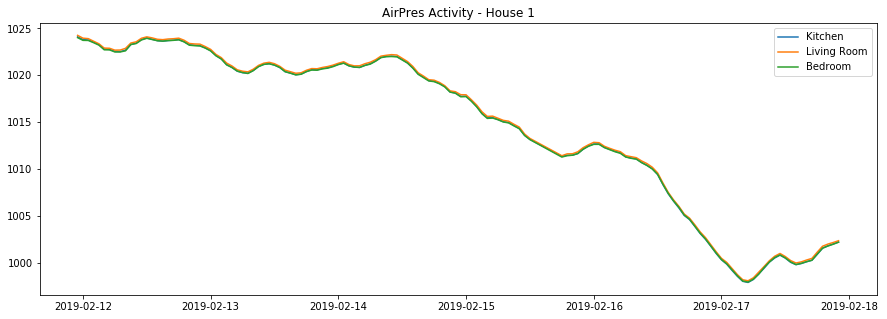

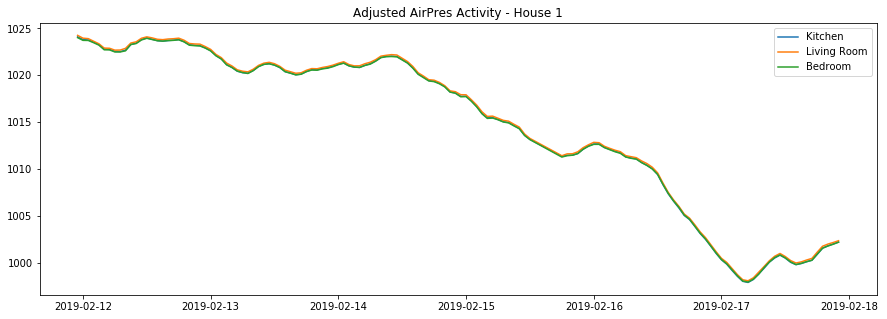

In [25]:
################################ H O U S E   1 ################################

KR1_Cal_AirPres_mean = Cal_KR["AirPres"][Cal_KR["House"]==2].mean()
LR1_Cal_AirPres_mean = Cal_LR["AirPres"][Cal_LR["House"]==2].mean()
BR1_Cal_AirPres_mean = Cal_BR["AirPres"][Cal_BR["House"]==2].mean()

H1_Cal_AirPres_mean = (KR1_Cal_AirPres_mean + LR1_Cal_AirPres_mean + BR1_Cal_AirPres_mean)/3

KR1_AirPres_adjustment = KR1_Cal_AirPres_mean - H1_Cal_AirPres_mean
LR1_AirPres_adjustment = LR1_Cal_AirPres_mean - H1_Cal_AirPres_mean
BR1_AirPres_adjustment = BR1_Cal_AirPres_mean - H1_Cal_AirPres_mean

IAQ_KR["AirPres"][IAQ_KR["House"]==2] -= KR1_AirPres_adjustment
IAQ_LR["AirPres"][IAQ_LR["House"]==2] -= LR1_AirPres_adjustment
IAQ_BR["AirPres"][IAQ_BR["House"]==2] -= BR1_AirPres_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("AirPres Activity - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 2], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 2], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Adjusted AirPres Activity - House 1")
plt.show();

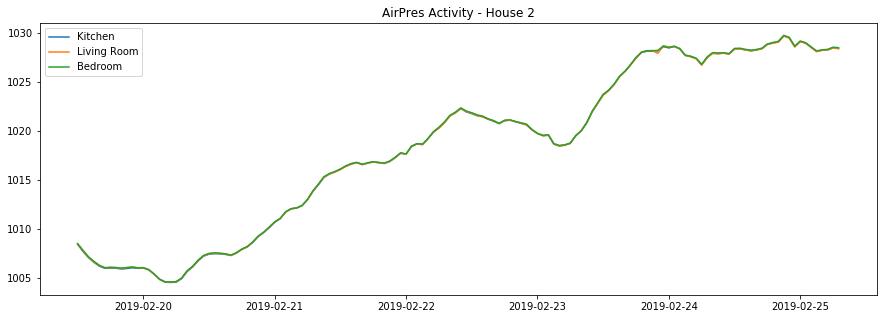

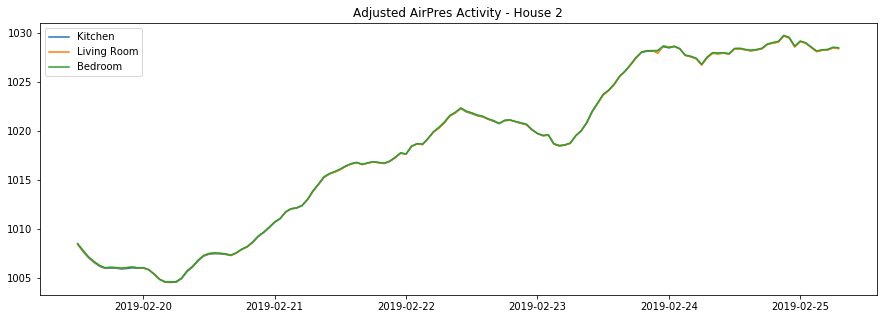

In [26]:
################################ H O U S E   2 ################################

KR2_Cal_AirPres_mean = Cal_KR["AirPres"][Cal_KR["House"]==3].mean()
LR2_Cal_AirPres_mean = Cal_LR["AirPres"][Cal_LR["House"]==3].mean()
BR2_Cal_AirPres_mean = Cal_BR["AirPres"][Cal_BR["House"]==3].mean()

H2_Cal_AirPres_mean = (KR2_Cal_AirPres_mean + LR2_Cal_AirPres_mean + BR2_Cal_AirPres_mean)/3

KR2_AirPres_adjustment = KR2_Cal_AirPres_mean - H2_Cal_AirPres_mean
LR2_AirPres_adjustment = LR2_Cal_AirPres_mean - H2_Cal_AirPres_mean
BR2_AirPres_adjustment = BR2_Cal_AirPres_mean - H2_Cal_AirPres_mean

IAQ_KR["AirPres"][IAQ_KR["House"]==3] -= KR2_AirPres_adjustment
IAQ_LR["AirPres"][IAQ_LR["House"]==3] -= LR2_AirPres_adjustment
IAQ_BR["AirPres"][IAQ_BR["House"]==3] -= BR2_AirPres_adjustment


plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("AirPres Activity - House 2")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(IAQ_KR["AirPres"][IAQ_KR["House"] == 3], label='Kitchen')
plt.plot(IAQ_LR["AirPres"][IAQ_LR["House"] == 3], label='Living Room')
plt.plot(IAQ_BR["AirPres"][IAQ_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Adjusted AirPres Activity - House 2")
plt.show();

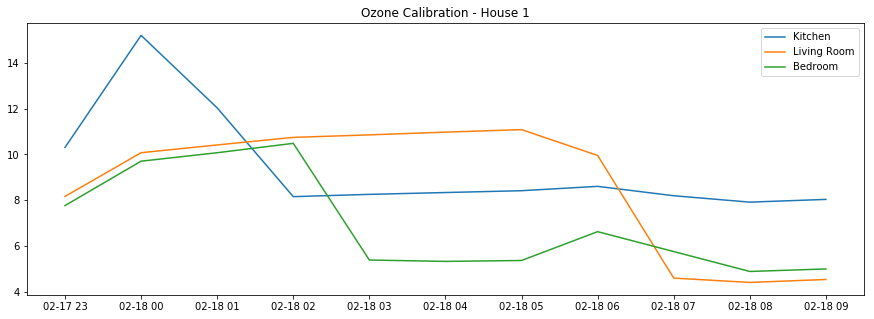

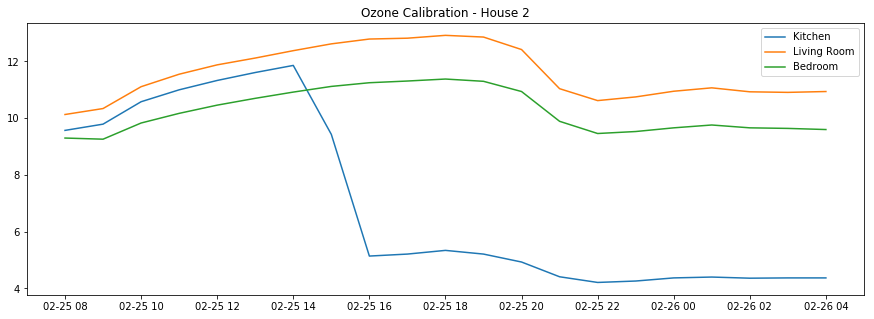

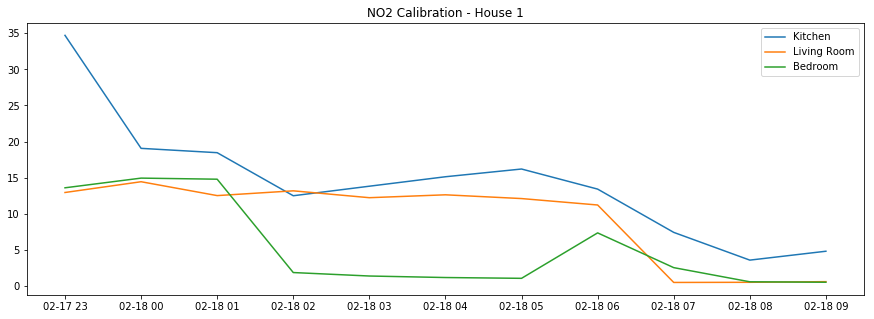

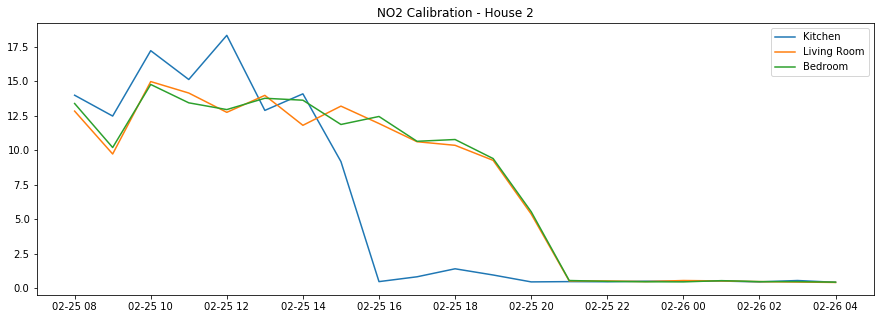

In [27]:
###############################################################################
############################ O Z O N E   &   N O 2 ############################
###############################################################################

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Ozone"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["Ozone"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["Ozone"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("Ozone Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["Ozone"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["Ozone"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["Ozone"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("Ozone Calibration - House 2")
plt.show();

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["NO2"][Cal_KR["House"] == 2], label='Kitchen')
plt.plot(Cal_LR["NO2"][Cal_LR["House"] == 2], label='Living Room')
plt.plot(Cal_BR["NO2"][Cal_BR["House"] == 2], label='Bedroom')
plt.legend()
plt.title("NO2 Calibration - House 1")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(Cal_KR["NO2"][Cal_KR["House"] == 3], label='Kitchen')
plt.plot(Cal_LR["NO2"][Cal_LR["House"] == 3], label='Living Room')
plt.plot(Cal_BR["NO2"][Cal_BR["House"] == 3], label='Bedroom')
plt.legend()
plt.title("NO2 Calibration - House 2")
plt.show();

In [28]:
#We're excluding Ozone and NO2 from our model since we couldn't find any agreement in the calibration data
#Here we join the sensor data from our 3 rooms, Living Room, Kitchen and Bedroom with all activity available

IAQ_LR = IAQ_LR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 
IAQ_KR = IAQ_KR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 
IAQ_BR = IAQ_BR.drop('TVOC', axis=1).rename(columns={"adj_TVOC": "TVOC"}) 

LR = pd.merge(IAQ_LR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)
KR = pd.merge(IAQ_KR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)
BR = pd.merge(IAQ_BR, activity, left_index=True, right_index=True).drop(["NO2", "Ozone"], axis=1)

In [29]:
#Here we create datasets for each room in each house and one for both rooms together. We do this as House 2 has slightly more
#features available than House 1. The purpose of this split is to analyze which features are most impactful to PM2.5 and if
#these features are equally impactful in both houses or not.

LR1 = LR[LR["House"] == 2].dropna(axis=1).drop(["House"], axis=1)
LR2 = LR[LR["House"] == 3].dropna(axis=1).drop(["House"], axis=1)
LR = LR.dropna(axis=1).drop(["House"], axis=1)

KR1 = KR[KR["House"] == 2].dropna(axis=1).drop(["House"], axis=1)
KR2 = KR[KR["House"] == 3].dropna(axis=1).drop(["House"], axis=1)
KR = KR.dropna(axis=1).drop(["House"], axis=1)

BR1 = BR[BR["House"] == 2].dropna(axis=1).drop(["House"], axis=1)
BR2 = BR[BR["House"] == 3].dropna(axis=1).drop(["House"], axis=1)
BR = BR.dropna(axis=1).drop(["House"], axis=1)

print("LR1 shape:",LR1.shape)
print("LR2 shape,",LR2.shape)
print("LR shape:",LR.shape)
print("\n")
print("KR1 shape:",KR1.shape)
print("KR2 shape,",KR2.shape)
print("KR shape:",KR.shape)
print("\n")
print("BR1 shape:",BR1.shape)
print("BR2 shape,",BR2.shape)
print("BR shape:",BR.shape)



LR1 shape: (131, 31)
LR2 shape, (139, 35)
LR shape: (270, 31)


KR1 shape: (131, 31)
KR2 shape, (139, 35)
KR shape: (270, 31)


BR1 shape: (131, 31)
BR2 shape, (139, 35)
BR shape: (270, 31)


In [30]:
print (LR1.columns)
print (LR2.columns)
print("\n")
print("House 2 has the following additional features to House 1: LR_OpenDoor, BR_OpenDoor, KR_OpenDoor and Shower")

Index(['Temp', 'RH', 'PM2.5', 'CO2', 'AirPres', 'TVOC', 'LR_MaxOccupancy',
       'LR_OpenWindow', 'LR_OpenCurtains', 'FireLit', 'LR_HeatingOn',
       'LR_Hoovering', 'LR_Mopping', 'KR_MaxOccupancy', 'KR_OpenCurtains',
       'Boiling', 'Frying', 'KR_HeatingOn', 'KR_Hoovering', 'KR_Mopping',
       'DishwasherOn', 'WashingMachineOn', 'Toaster', 'BR_MaxOccupancy',
       'BR_OpenWindows', 'BR_OpenCurtains', 'BR_HeatingOn', 'BR_Hoovering',
       'BR_Mopping', 'Hour', 'timeOfDay'],
      dtype='object')
Index(['Temp', 'RH', 'PM2.5', 'CO2', 'AirPres', 'TVOC', 'LR_MaxOccupancy',
       'LR_OpenWindow', 'LR_OpenDoor', 'LR_OpenCurtains', 'FireLit',
       'LR_HeatingOn', 'LR_Hoovering', 'LR_Mopping', 'KR_MaxOccupancy',
       'KR_OpenDoor', 'KR_OpenCurtains', 'Boiling', 'Frying', 'KR_HeatingOn',
       'KR_Hoovering', 'KR_Mopping', 'DishwasherOn', 'WashingMachineOn',
       'Toaster', 'BR_MaxOccupancy', 'BR_OpenWindows', 'BR_OpenDoor',
       'BR_OpenCurtains', 'BR_HeatingOn', 'BR_Hoovering

In [31]:
#Creating a DF for House 1 (H1), House 2 (H2) and both houses (H) with rooms one-hot encoded in case I need it for something.
df1_1 = LR1.copy()
df1_2 = KR1.copy()
df1_3 = BR1.copy()

df2_1 = LR2.copy()
df2_2 = KR2.copy()
df2_3 = BR2.copy()

df1_1["LivingRoom"] = 1
df1_1["Kitchen"] = 0
df1_1["Bedroom"] = 0

df1_2["LivingRoom"] = 0
df1_2["Kitchen"] = 1
df1_2["Bedroom"] = 0

df1_3["LivingRoom"] = 0
df1_3["Kitchen"] = 0
df1_3["Bedroom"] = 1

df2_1["LivingRoom"] = 1
df2_1["Kitchen"] = 0
df2_1["Bedroom"] = 0

df2_2["LivingRoom"] = 0
df2_2["Kitchen"] = 1
df2_2["Bedroom"] = 0

df2_3["LivingRoom"] = 0
df2_3["Kitchen"] = 0
df2_3["Bedroom"] = 1


H1 = pd.concat([df1_1, df1_2, df1_3], axis=0, sort=False)
H2 = pd.concat([df2_1, df2_2, df2_3], axis=0, sort=False)

H = pd.concat([H1, H2], axis=0, sort=False).dropna(axis=1)

print("H1 shape:",H1.shape)
print("H2 shape:",H2.shape)
print("H shape:",H.shape)

H1 shape: (393, 34)
H2 shape: (417, 38)
H shape: (810, 34)


# Questions needing answering so far:

### Is there a way to better use the calibration data on our activity?
### Assuming the way the sensors were adjusted is acceptable, is there a better way to treat the TVOC data?

# Exploratory Data Analysis

## Goals of this section:

### We're dealing with two similar layout houses. Both houses have the Kitchen joined with the Living room and then a bedroom too.

### 1 - Comparing means, standard deviations, mins and maximums between rooms in House 1 and 2; 6 comparisons.

### 2 - Comparing means between Activities' 1s and 0s. A "1" represents "On/Open/Yes", such as Heating On, Door Open, Frying occurred.

### 3 - We'll look into collinearity in this section as well as to prevent having a model with many features irrelevant to the change of PM2.5

### 4 - Realted to the mins/max comparison, we'll look at outliers and consult our activity logs to try and explain what could have happened there

In [ ]:
#Adding old block of code here just to remember what needs to be done

print("House 2 - Living Room")
print("Mean:", round(IAQ_LR["CO2"]  [(IAQ_LR["House"] == 2) & (IAQ_LR["Calibration"] == 0)].mean(),4))
print("SD:   ",round(IAQ_LR["CO2"]  [(IAQ_LR["House"] == 2) & (IAQ_LR["Calibration"] == 0)].std(),4))
print("Min: ", round(IAQ_LR["CO2"]  [(IAQ_LR["House"] == 2) & (IAQ_LR["Calibration"] == 0)].min(),4))
print("Max:  ",round(IAQ_LR["CO2"]  [(IAQ_LR["House"] == 2) & (IAQ_LR["Calibration"] == 0)].max(),4))

In [ ]:
###############################################################################
######################## S T A N D A R D I Z A T I O N ########################
###############################################################################

LR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres','BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     LR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
             'LR_MaxOccupancy','KR_MaxOccupancy']])

KR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     KR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

BR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     BR1[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

LR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     LR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

KR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     KR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

BR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
     'LR_MaxOccupancy','KR_MaxOccupancy']] = StandardScaler().fit_transform(
     BR2[['Temp', 'RH', 'PM2.5', 'TVOC', 'CO2', 'AirPres', 'BR_MaxOccupancy', 
          'LR_MaxOccupancy','KR_MaxOccupancy']])

In [ ]:
#Boxplots (work in progress)

plt.figure(figsize=(18,7))
sns.boxplot(x=LR['House'], y=LR['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 by House")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=KR['House'], y=KR['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 by House")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=BR['House'], y=BR['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 by House")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=LR['timeOfDay'], y=LR['PM2.5'], orient='v')
plt.title(label="Living Room PM2.5 by Time of Day")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=KR['timeOfDay'], y=KR['PM2.5'], orient='v')
plt.title(label="Kitchen PM2.5 by Time of Day")
plt.show()
plt.figure(figsize=(18,7))
sns.boxplot(x=BR['timeOfDay'], y=BR['PM2.5'], orient='v')
plt.title(label="Bedroom PM2.5 by Time of Day")
plt.show();

In [ ]:
#Steplots (work in progress)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.step(x=BR3.index, y=BR3["BR_MaxOccupancy"]);
plt.title('CO2 v BR_MaxOccupancy')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.step(x=BR3.index, y=BR3["BR_OpenWindows"]);
plt.title('CO2 v BR_OpenWindows')
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v BR_OpenDoor')
plt.step(x=BR3.index, y=BR3["BR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v BR_OpenCurtains')
plt.step(x=BR3.index, y=BR3["BR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v BR_HeatingOn')
plt.step(x=BR3.index, y=BR3["BR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v BR_Hoovering')
plt.step(x=BR3.index, y=BR3["BR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v BR_Mopping')
plt.step(x=BR3.index, y=BR3["BR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_MaxOccupancy')
plt.step(x=BR3.index, y=BR3["LR_MaxOccupancy"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_OpenWindow')
plt.step(x=BR3.index, y=BR3["LR_OpenWindow"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_OpenDoor')
plt.step(x=BR3.index, y=BR3["LR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_OpenCurtains')
plt.step(x=BR3.index, y=BR3["LR_OpenCurtains"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_HeatingOn')
plt.step(x=BR3.index, y=BR3["LR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_Hoovering')
plt.step(x=BR3.index, y=BR3["LR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v LR_Mopping')
plt.step(x=BR3.index, y=BR3["LR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v KR_OpenDoor')
plt.step(x=BR3.index, y=BR3["KR_OpenDoor"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v Boiling')
plt.step(x=BR3.index, y=BR3["Boiling"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v Frying')
plt.step(x=BR3.index, y=BR3["Frying"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v KR_HeatingOn')
plt.step(x=BR3.index, y=BR3["KR_HeatingOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v KR_Hoovering')
plt.step(x=BR3.index, y=BR3["KR_Hoovering"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v KR_Mopping')
plt.step(x=BR3.index, y=BR3["KR_Mopping"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v DishwasherOn')
plt.step(x=BR3.index, y=BR3["DishwasherOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v WashingMachineOn')
plt.step(x=BR3.index, y=BR3["WashingMachineOn"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v Toaster')
plt.step(x=BR3.index, y=BR3["Toaster"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v Toaster')
plt.step(x=BR3.index, y=BR3["Hour"]);
plt.show()

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(BR3["CO2"])
plt.title('CO2 v Toaster')
plt.step(x=BR3.index, y=BR3["timeOfDay"]);
plt.show()


# Modeling

## Only template models looked at so far with no hyper-tuning. Planning on trying linear regression with nonlinear parameters, Random Forest and Support Vector.

In [ ]:
#This function has an option to run a model with all variables and just sensor data to see how impactful our occupant 
#activity is on the model.

def train_test (df, allVars):
        
    if allVars == True:
        X = df.drop(["PM2.5"], axis=1)
    else:
        X = df[['Temp', 'RH', 'TVOC', 'CO2', 'AirPres']]
        
    y = df["PM2.5"]

    X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)
    
    return (X_train, X_test, y_train, y_test, X, y)

In [ ]:
X_train, X_test, y_train, y_test, X, y = train_test(KR2, True)

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

In [ ]:
#1.1. - Linear Regression ---------------------------#
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)
y_pred = model.predict(X_test)

print('Coefficients: \n', model.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print('Cross Validation scores:',cross_val_score(model, X_train, y_train, cv=10))

In [ ]:
#1.2. - Decision Tree ---------------------------#
model = tree.DecisionTreeRegressor()
model.fit(X_train, y_train)
model.score(X_train, y_train)
y_pred= model.predict(X_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print(cross_val_score(model, X_train, y_train, cv=10))

In [ ]:
#1.3. - Random Forest ---------------------------#
model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
model.fit(X, y)
y_pred = model.predict(X_test)

print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2), 'degrees.')
print('Mean Squared Error:',round(mean_squared_error(y_test, y_pred),4))
print('Accuracy:', r2_score(y_test, y_pred))
print(cross_val_score(model, X_train, y_train, cv=10))